In [2]:
# MOD per system
import sys
sys.path.append('C:/Users/emiga/OneDrive/Cal/GWs/code/holodeck') 


# %load ../init.ipy
%reload_ext autoreload
%autoreload 2
from importlib import reload

import os
import sys
import logging
import warnings
import numpy as np
import astropy as ap
import scipy as sp
import scipy.stats
import matplotlib as mpl
import matplotlib.pyplot as plt

import h5py
import tqdm.notebook as tqdm

import kalepy as kale
import kalepy.utils
import kalepy.plot

import holodeck as holo
import holodeck.sam
from holodeck import cosmo, utils, plot
from holodeck.constants import MSOL, PC, YR, MPC, GYR

# Silence annoying numpy errors
np.seterr(divide='ignore', invalid='ignore', over='ignore')
warnings.filterwarnings("ignore", category=UserWarning)

# Plotting settings
mpl.rc('font', **{'family': 'serif', 'sans-serif': ['Times'], 'size': 15})
mpl.rc('lines', solid_capstyle='round')
mpl.rc('mathtext', fontset='cm')
mpl.style.use('default')   # avoid dark backgrounds from dark theme vscode
plt.rcParams.update({'grid.alpha': 0.5})

log = holo.log
log.setLevel(logging.INFO)

In [12]:
def gws_by_loops(edges, number, realize, print_test = False):
       
    """ Inefficient way to calculate strain from numbered 
    grid integrated

    Parameters
    ----------
    edges : (4,) list of 1darrays
        A list containing the edges along each dimension.  The four dimensions correspond to
        total mass, mass ratio, redshift, and observer-frame orbital frequency.
        The length of each of the four arrays is M, Q, Z, F.
    number : (M-1, Q-1, Z-1, F-1) ndarray
        The number of binaries in each bin of parameter space.  This is calculated by integrating
        `dnum` over each bin.
    realize : bool or int,
        Specification of how to construct one or more discrete realizations.
        If a `bool` value, then whether or not to construct a realization.
        If an `int` value, then how many discrete realizations to construct.
    print_test : bool
        Whether or not to print variables as they are calculated, for dev purposes.


    Returns
    -------
    hc : ndarray
        Characteristic strain of the GWB.
        The shape depends on whether realize is an integer or not
        realize = True or False: shape is (M-1, Q-1, Z-1, F-1)
        realize = R: shape is  (M-1, Q-1, Z-1, F-1, R)

    """
    if(print_test):
        print('INPUTS: edges:', len(edges), '\n', edges, 
        '\nINPUTS:number:', number.shape, '\n', number,'\n')

    # Frequency bin midpoints
    foo = edges[-1]                   #: should be observer-frame orbital-frequencies
    df = np.diff(foo)                 #: frequency bin widths
    fc = kale.utils.midpoints(foo)    #: use frequency-bin centers for strain (more accurate!)

    # All other bin midpoints
    mt = kale.utils.midpoints(edges[0]) #: total mass
    mr = kale.utils.midpoints(edges[1]) #: mass ratio
    rz = kale.utils.midpoints(edges[2]) #: redshift

    if(print_test):
        print('Observer frame frequency centers: ', fc)
        print('Mass edges: ', mt.shape, mt)
        print('Ratio edges:', mr.shape, mr)
        print('Redshift edges:', rz.shape, rz,'\n')

    
    # make strain grid
    hc_grid = np.empty_like(number)

    # for r realizations, make a grid with shape 
    # m, q, z, f, r
    if(utils.isinteger(realize)):
        newshape = hc_grid.shape + (realize,)
        if(print_test):
            print('newshape:', newshape)
        realized_grid = np.empty(newshape)

    # get strain for each bin
    for m_idx in range(len(mt)):
        for q_idx in range(len(mr)):
            for z_idx in range(len(rz)):
                cmass = holo.utils.chirp_mass_mtmr(mt[m_idx], mr[q_idx])
                cdist = holo.cosmo.comoving_distance(rz[z_idx]).cgs.value
                
                # print M, q, z, M_c, d_c
                if(print_test):
                    print('BIN mt=%.2e, mr=%.2e, rz=%.2e' %
                        (mt[m_idx], mr[q_idx], rz[z_idx]))
                    print('\t m_c = %.2e, d_c = %.2e' 
                        % (cmass, cdist))

                for f_idx in range(len(fc)):
                    rfreq = holo.utils.frst_from_fobs(fc[f_idx], rz[z_idx])
                    hs_mqzf = utils.gw_strain_source(cmass, cdist, rfreq)
                    hc_dlnf = hs_mqzf**2 * (fc[f_idx]/df[f_idx])
                    
                    if(realize == False):
                        hc_grid[m_idx, q_idx, z_idx, f_idx] = np.sqrt(hc_dlnf 
                                        * number[m_idx, q_idx, z_idx, f_idx])
                    elif(realize == True):
                        hc_grid[m_idx, q_idx, z_idx, f_idx] = np.sqrt(hc_dlnf 
                                        *np.random.poisson(number[m_idx, q_idx, z_idx, f_idx]))
                    elif(utils.isinteger(realize)):
                        for r_idx in range(realize):
                            realized_grid[m_idx, q_idx, z_idx, f_idx, r_idx] = \
                                np.sqrt(hc_dlnf 
                                        *np.random.poisson(number[m_idx, q_idx, z_idx, f_idx]))
                        hc_grid = realized_grid                
                    else:
                        print("`realize` ({}) must be one of {{True, False, integer}}!"\
                            .format(realize))

                     # print fr, hs, hc^2/dlnf, number, hc
                    if(print_test):
                        print('\t\tfr = %.2fnHz, h_s = %.2e, h_c^2/dlnf = %.2e' 
                            % (rfreq*10**9, hs_mqzf, hc_dlnf))
                        print('\t\tnumber: %.2e' % number[m_idx, q_idx, z_idx, f_idx])
                        print('\t\thc = %.2e' % hc_grid[m_idx, q_idx, z_idx, f_idx])
    return hc_grid


In [13]:
# Not yet implemented, ignore for now

def gws_half_loops(edges, number, realize, print_test = False):
       
    """ Inefficient way to calculate strain from numbered 
    grid integrated, using slightly fewer calculations inside loops

    Parameters
    ----------
    edges : (4,) list of 1darrays
        A list containing the edges along each dimension.  The four dimensions correspond to
        total mass, mass ratio, redshift, and observer-frame orbital frequency.
        The length of each of the four arrays is M, Q, Z, F.
    number : (M-1, Q-1, Z-1, F-1) ndarray
        The number of binaries in each bin of parameter space.  This is calculated by integrating
        `dnum` over each bin.
    realize : bool or int,
        Specification of how to construct one or more discrete realizations.
        If a `bool` value, then whether or not to construct a realization.
        If an `int` value, then how many discrete realizations to construct.
    print_test : bool
        Whether or not to print variables as they are calculated, for dev purposes.


    Returns
    -------
    hc : ndarray
        Characteristic strain of the GWB.
        The shape depends on whether realize is an integer or not
        realize = True or False: shape is (M-1, Q-1, Z-1, F-1)
        realize = R: shape is  (M-1, Q-1, Z-1, F-1, R)

    """
    if(print_test):
        print('INPUTS: edges:', len(edges), '\n', edges, 
        '\nINPUTS:number:', number.shape, '\n', number,'\n')

    # Frequency bin midpoints
    foo = edges[-1]                   #: should be observer-frame orbital-frequencies
    df = np.diff(foo)                 #: frequency bin widths
    fc = kale.utils.midpoints(foo)    #: use frequency-bin centers for strain (more accurate!)

    # All other bin midpoints
    mt = kale.utils.midpoints(edges[0]) #: total mass
    mr = kale.utils.midpoints(edges[1]) #: mass ratio
    rz = kale.utils.midpoints(edges[2]) #: redshift

    if(print_test):
        print('Observer frame frequency centers: ', fc)
        print('Mass edges: ', mt.shape, mt)
        print('Ratio edges:', mr.shape, mr)
        print('Redshift edges:', rz.shape, rz,'\n')

    # Chirp mass and comoving distance
    # mc = utils.chirp_mass_mtmr(mt[:, np.newaxis], mr[np.newaxis, :])
    # dc = holo.cosmo.comoving_distance(rz).cgs.value
    # if(print_test):
    #     print('Chirp mass', mc.shape, '\n', mc)
        # print('Comoving distance:', dc,'\n')

    # Convert freq bin centers to rest-frame
    # fr = utils.frst_from_fobs(fc[np.newaxis, :], rz[:, np.newaxis])
    # if(print_test):
    #     print('Rest frame frequency centers:', fr.shape, 
    #         '\n',fr,'\n')
    
    # get strain for each bin
    hc_grid = np.empty_like(number)
    for m_idx in range(len(mt)):
        for q_idx in range(len(mr)):
            for z_idx in range(len(rz)):
                cmass = holo.utils.chirp_mass_mtmr(mt[m_idx], mr[q_idx])
                cdist = holo.cosmo.comoving_distance(rz[z_idx]).cgs.value
                if(print_test):
                    print('BIN mt=%.2e, mr=%.2e, rz=%.2e' %
                        (mt[m_idx], mr[q_idx], rz[z_idx]))
                    print('\t m_c = %.2e, d_c = %.2e' 
                        % (cmass, cdist))
                for f_idx in range(len(fc)):
                    rfreq = holo.utils.frst_from_fobs(fc[f_idx], rz[z_idx])
                    hs_mqzf = utils.gw_strain_source(cmass, cdist, rfreq)
                    hc_dlnf = hs_mqzf**2 * (fc[f_idx]/df[f_idx])
                    if(print_test):
                        print('\t\tfr = %.2fnHz, h_s = %.2e, h_c^2/dlnf = %.2e' 
                            % (rfreq*10**9, hs_mqzf, hc_dlnf))
                        print('\t\tnumber: %.2e' % number[m_idx, q_idx, z_idx, f_idx])
                    if(realize == False):
                        hc_grid[m_idx, q_idx, z_idx, f_idx] = np.sqrt(hc_dlnf 
                                        * number[m_idx, q_idx, z_idx, f_idx])
                    elif(realize == True):
                        hc_grid[m_idx, q_idx, z_idx, f_idx] = np.sqrt(hc_dlnf 
                                        *np.random.poisson(number[m_idx, q_idx, z_idx, f_idx]))
                    else:
                        print('cant do multiple realizations yet')
                    if(print_test):
                        print('\t\thc = %.2e' % hc_grid[m_idx, q_idx, z_idx, f_idx])



    # if(realize == False):
    #     hc_grid *= number
    # elif(realize == True):
    #     hc_grid *= np.random.poisson(number)

    #not sure if this part will work
    # elif utils.isinteger(realize):
    #     try:
    #         realizations = np.empty(realize)
    #         for real in range(realize): 
    #             realizations[real]= gws_by_loops(edges, number, realize=True)
    #         hc_grid = realizations
    #     except:
    #         print("Something went wrong when you tried to do multiple realizations.")
    print('hc:', hc.shape)

    return hc_grid

# SAM Edges and Number for Example

frequency bins/edges

In [14]:
dur = 5.0*YR/3.1557600
cad = .5*YR/3.1557600
fobs = utils.nyquist_freqs(dur,cad)
fobs_edges = utils.nyquist_freqs_edges(dur,cad)
print(f"Number of frequency bins: {fobs.size-1}")
print(f"  between [{fobs[0]*YR:.2f}, {fobs[-1]*YR:.2f}] 1/yr")
print(f"          [{fobs[0]*1e9:.2f}, {fobs[-1]*1e9:.2f}] nHz")

Number of frequency bins: 4
  between [0.63, 3.16] 1/yr
          [20.00, 100.00] nHz


Semi-Analytic-Model with default parameters 
* gsmf=GSMF_Schechter, 
* gpf=GPF_Power_Law, 
* gmt=GMT_Power_Law, 
* mmbulge=relations.MMBulge_MM2013

In [15]:
mtot=(1.0e6*MSOL/1.988409870698051, 1.0e8*MSOL/1.988409870698051, 3)
mrat=(1e-1, 1.0, 2)
redz=(1e-3, 1.0, 4)
sam = holo.sam.Semi_Analytic_Model(mtot=mtot, mrat=mrat, 
        redz=redz)
print('edges:', sam.edges)

edges: [array([1.e+39, 1.e+40, 1.e+41]), array([0.1, 1. ]), array([0.001, 0.01 , 0.1  , 1.   ])]


gwb (internal to sam.gwb excluding hc calculation)

In [16]:
fobs_gw_edges = fobs_edges
hard = holo.hardening.Hard_GW
fobs_gw_cents = kale.utils.midpoints(fobs_gw_edges)
fobs_orb_edges = fobs_gw_edges / 2.0
fobs_orb_cents = fobs_gw_cents / 2.0


# dynamic_binary_number
# gets differential number of binaries per bin-vol per log freq interval
edges, dnum = sam.dynamic_binary_number(hard, fobs_orb=fobs_orb_cents)
edges[-1] = fobs_orb_edges

# integrate (multiply by bin volume) within each bin
number = utils._integrate_grid_differential_number(edges, dnum, freq=False)
number = number * np.diff(np.log(fobs_gw_edges))

In [17]:
np.set_printoptions(precision = 4)
loop_hcF = gws_by_loops(edges, number, realize = False, print_test=True)
np.set_printoptions(precision = None)

INPUTS: edges: 4 
 [array([1.e+39, 1.e+40, 1.e+41]), array([0.1, 1. ]), array([0.001, 0.01 , 0.1  , 1.   ]), array([5.0e-09, 1.5e-08, 2.5e-08, 3.5e-08, 4.5e-08, 6.0e-08])] 
INPUTS:number: (2, 1, 3, 5) 
 [[[[0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]
   [8.8275e+06 6.4642e+05 1.4442e+05 5.0086e+04 2.7764e+04]
   [1.0939e+09 8.0105e+07 1.7896e+07 6.2067e+06 3.4405e+06]]]


 [[[0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]
   [1.0989e+05 8.0473e+03 1.7978e+03 6.2351e+02 3.4563e+02]
   [1.2899e+07 9.4460e+05 2.1103e+05 7.3189e+04 4.0571e+04]]]] 

Observer frame frequency centers:  [1.00e-08 2.00e-08 3.00e-08 4.00e-08 5.25e-08]
Mass edges:  (2,) [5.5e+39 5.5e+40]
Ratio edges: (1,) [0.55]
Redshift edges: (3,) [0.0055 0.055  0.55  ] 

BIN mt=5.50e+39, mr=5.50e-01, rz=5.50e-03
	 m_c = 2.27e+39, d_c = 7.33e+25
		fr = 10.06nHz, h_s = 2.92e-19, h_c^2/dlnf = 8.53e-38
		number: 0.00e+00
		hc = 0.00e+00
		fr = 20.11nHz, h_s = 4.64e-19, h_c^2/dlnf = 4.30e-37
		number: 0.00e+00


# Test Cases

In [32]:
# get GWB spectrum
hc_samF = holo.sam.gravwaves._gws_from_number_grid_integrated(edges, number, realize=False, sum=False)
hc_samF_sum = holo.sam.gravwaves._gws_from_number_grid_integrated(edges, number, realize=False, sum=True)
hc_samT = holo.sam.gravwaves._gws_from_number_grid_integrated(edges, number, realize=True, sum=False)
hc_sam1 = holo.sam.gravwaves._gws_from_number_grid_integrated(edges, number, realize=1, sum=False)
hc_sam3 = holo.sam.gravwaves._gws_from_number_grid_integrated(edges, number, realize=3, sum=False)
hc_sam3_sum = holo.sam.gravwaves._gws_from_number_grid_integrated(edges, number, realize=3, sum=True)

hc_loopF = gws_by_loops(edges, number, realize=False)   
hc_loopF_sum = np.sqrt(np.sum(hc_loopF**2, axis=(0, 1, 2))) 
hc_loopT = gws_by_loops(edges, number, realize=True)
hc_loop1 = gws_by_loops(edges, number, realize=1)   
hc_loop3 = gws_by_loops(edges, number, realize=3)   
hc_loop3_sum = np.sqrt(np.sum(hc_loop3**2, axis=(0, 1, 2)))
        

In [21]:
print(hc_samF == hc_loopF)
# should be exact same
print('hc by sam:\n', hc_samF)
print('hc by loop:\n', hc_loopF)

[[[[ True  True  True  True  True]
   [ True  True  True  True  True]
   [ True  True  True  True  True]]]


 [[[ True  True  True  True  True]
   [ True  True  True  True  True]
   [ True  True  True  True  True]]]]
hc by sam:
 [[[[0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]
   [9.0566e-17 5.5019e-17 4.1735e-17 3.4380e-17 2.8703e-17]
   [1.4725e-16 8.9455e-17 6.7857e-17 5.5899e-17 4.6668e-17]]]


 [[[0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]
   [4.6903e-16 2.8493e-16 2.1614e-16 1.7805e-16 1.4865e-16]
   [7.4220e-16 4.5088e-16 3.4202e-16 2.8175e-16 2.3522e-16]]]]
hc by loop:
 [[[[0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]
   [9.0566e-17 5.5019e-17 4.1735e-17 3.4380e-17 2.8703e-17]
   [1.4725e-16 8.9455e-17 6.7857e-17 5.5899e-17 4.6668e-17]]]


 [[[0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]
   [4.6903e-16 2.8493e-16 2.1614e-16 1.7805e-16 1.4865e-16]
   [7.4220e-16 4.5088e-16 3.4202e-16 2.8175e-16 2.3522e-16]]]]


In [69]:
print(hc_samF_sum == hc_loopF_sum)
# should be exact same
print('hc sum by sam:\n', hc_samF_sum)
print('hc sum by loop:\n', hc_loopF_sum)

[ True  True  True  True  True]
hc sum by sam:
 [8.9484e-16 5.4361e-16 4.1236e-16 3.3969e-16 2.8360e-16]
hc sum by loop:
 [8.9484e-16 5.4361e-16 4.1236e-16 3.3969e-16 2.8360e-16]


In [23]:
print(np.max(hc_sam3-hc_loop3))
print(hc_sam3 - hc_loop3)
# should be different but by pretty low numbers

6.6714594480582095e-18
[[[[[ 0.0000e+00  0.0000e+00  0.0000e+00]
    [ 0.0000e+00  0.0000e+00  0.0000e+00]
    [ 0.0000e+00  0.0000e+00  0.0000e+00]
    [ 0.0000e+00  0.0000e+00  0.0000e+00]
    [ 0.0000e+00  0.0000e+00  0.0000e+00]]

   [[ 8.1054e-22  5.4219e-21  1.2697e-20]
    [ 4.0039e-20  3.0637e-21 -2.8106e-21]
    [-4.2780e-20 -2.4562e-20  3.4537e-20]
    [-5.8742e-20  2.0563e-20 -1.4776e-20]
    [-6.7734e-20  2.3275e-20 -2.5104e-19]]

   [[ 2.5149e-21  2.2191e-21 -1.3415e-21]
    [-1.9110e-20  4.7529e-21  6.3803e-21]
    [ 1.6636e-20 -1.2873e-21  6.1060e-21]
    [ 1.5757e-21 -2.2079e-20  1.9509e-20]
    [-1.3227e-21  2.4511e-20  1.8035e-20]]]]



 [[[[ 0.0000e+00  0.0000e+00  0.0000e+00]
    [ 0.0000e+00  0.0000e+00  0.0000e+00]
    [ 0.0000e+00  0.0000e+00  0.0000e+00]
    [ 0.0000e+00  0.0000e+00  0.0000e+00]
    [ 0.0000e+00  0.0000e+00  0.0000e+00]]

   [[-4.5436e-19 -9.7071e-19 -1.0439e-19]
    [-1.7717e-19 -7.4237e-19  2.6633e-18]
    [ 6.6715e-18  1.0816e-18  4.8177e-18]

In [68]:
print(np.max(hc_sam3_sum-hc_loop3_sum))
print(hc_sam3_sum - hc_loop3_sum)
# should be different but by pretty low numbers

5.207673263596318e-18
[[-7.6740e-19  6.1423e-19 -1.1280e-18]
 [-1.6909e-18  1.3780e-18 -1.2051e-18]
 [-5.4205e-19  1.0020e-18 -4.8279e-19]
 [ 1.9991e-18  5.2077e-18  2.8975e-18]
 [-6.0367e-18  2.0921e-18 -1.7081e-18]]


## Plot test cases strain vs frequency

In [48]:
def add_sampleGWB_to_plot(fig, ax, PLOT_GWB, LABEL, COLOR='b'):
    nsamp = PLOT_GWB.shape[1]
    ax.plot(xx, np.median(PLOT_GWB, axis=1), color=COLOR, label=LABEL)
    # plot contours at 50% and 98% confidence intervals
    for pp in [50, 98]:
        percs = pp / 2
        percs = [50 - percs, 50 + percs]
        ax.fill_between(xx, *np.percentile(PLOT_GWB, percs, axis=-1), alpha=0.25, color=COLOR)
    # Plot `nsamp` random spectra 
    
    idx = np.random.choice(PLOT_GWB.shape[1], nsamp, replace=False)
    ax.plot(xx, PLOT_GWB[:, idx], lw=1.0, alpha=0.5, color=COLOR, linestyle = 'dotted')

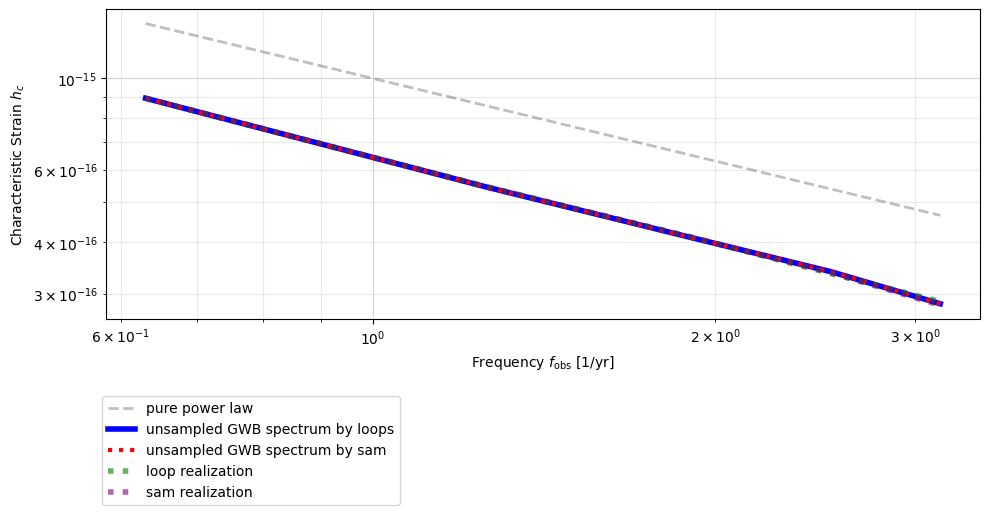

In [102]:
# Plot just this one realization
fig, ax = plot.figax(xlabel='Frequency $f_\mathrm{obs}$ [1/yr]', 
                    ylabel='Characteristic Strain $h_c$', figsize=[10,4.5])

xx = fobs * YR

# plot a reference, pure power-law  strain spectrum:   h_c(f) = 1e-15 * (f * yr) ^ -2/3
yy = 1e-15 * np.power(xx, -2.0/3.0)
ax.plot(xx, yy, 'k--', alpha=0.25, lw=2.0, label = 'pure power law')

# plot the model without sampling
# blue: my loop method
# red: the sam method
ax.plot(xx, hc_loopF_sum, color='b', lw=4, ls = 'solid', label='unsampled GWB spectrum by loops')
ax.plot(xx, hc_samF_sum, color='r', lw=3, ls = 'dotted', label='unsampled GWB spectrum by sam')

# plot the model with Poisson sampling
# add_sampleGWB_to_plot(fig, ax, hc_loop3_sum, LABEL='loop with 3 realizations', COLOR='b')
# add_sampleGWB_to_plot(fig, ax, hc_sam3_sum, LABEL='sam with 3 realizations', COLOR='r')

# plot single realizations
ax.plot(xx, hc_loop3_sum[:, 0], lw=4.0, alpha=0.6, color='green', linestyle = 'dotted',
        label = 'loop realization')
ax.plot(xx, hc_sam3_sum[:, 0], lw=4.0, alpha=0.6, color='purple', linestyle = 'dotted',
        label = 'sam realization')


legend_gwb = ax.legend(bbox_to_anchor=(.1,-.15), bbox_transform=fig.transFigure, loc='lower left')
fig.tight_layout()

Everything appears to be along the unsampled line, even using the sam realization model,
maybe because of the simplicity of my example. I'll try and more complex case with more realizations below.

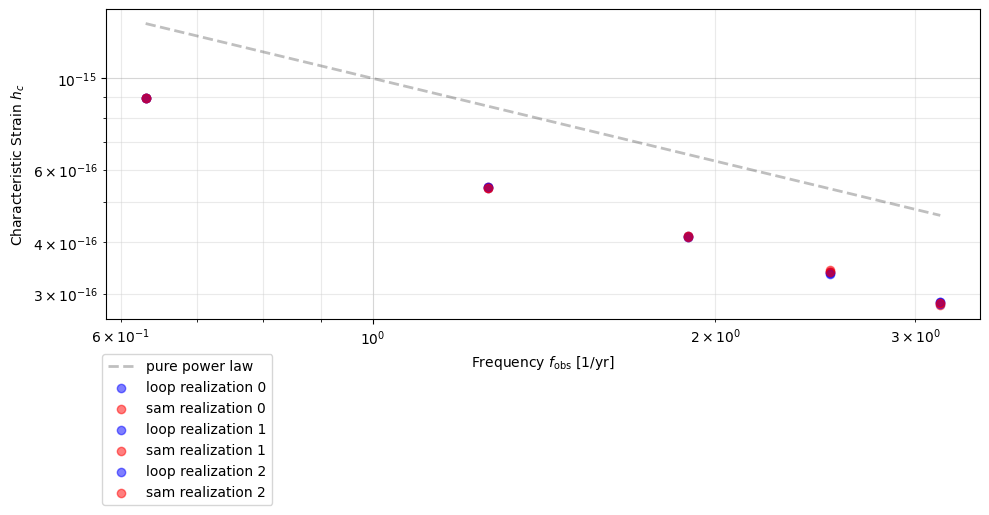

In [80]:
# Plot just this one realization
fig, ax = plot.figax(xlabel='Frequency $f_\mathrm{obs}$ [1/yr]', 
                    ylabel='Characteristic Strain $h_c$', figsize=[10,4.5])

xx = fobs * YR

# plot a reference, pure power-law  strain spectrum:   h_c(f) = 1e-15 * (f * yr) ^ -2/3
yy = 1e-15 * np.power(xx, -2.0/3.0)
ax.plot(xx, yy, 'k--', alpha=0.25, lw=2.0, label = 'pure power law')

# # plot the model without sampling
# # blue: my loop method
# # red: the sam method
# ax.plot(xx, hc_loopF_sum, color='b', lw=4, ls = 'solid', label='unsampled GWB spectrum by loops')
# ax.plot(xx, hc_samF_sum, color='r', lw=3, ls = 'dotted', label='unsampled GWB spectrum by sam')

# # plot the model with Poisson sampling
# add_sampleGWB_to_plot(fig, ax, hc_loop3_sum, LABEL='loop with 3 realizations', COLOR='b')
# add_sampleGWB_to_plot(fig, ax, hc_sam3_sum, LABEL='sam with 3 realizations', COLOR='r')

# plot single realizations
for idx in range(3):
        ax.scatter(xx, hc_loop3_sum[:, idx], lw=1.0, alpha=0.5, color='b', 
                label = 'loop realization %d' % idx)
        ax.scatter(xx, hc_sam3_sum[:, idx], lw=1.0, alpha=0.5, color='r', 
                label = 'sam realization %d' % idx)


legend_gwb = ax.legend(bbox_to_anchor=(.1,-.15), bbox_transform=fig.transFigure, loc='lower left')
fig.tight_layout()

There are slight variations between them. This looks pretty good to me!

## More realizations

In [93]:
# get GWB spectrum
hc_sam10 = holo.sam.gravwaves._gws_from_number_grid_integrated(edges, number, realize=10, sum=False)
hc_sam10_sum = holo.sam.gravwaves._gws_from_number_grid_integrated(edges, number, realize=10, sum=True)
  
hc_loop10 = gws_by_loops(edges, number, realize=10)   
hc_loop10_sum = np.sqrt(np.sum(hc_loop10**2, axis=(0, 1, 2)))
        

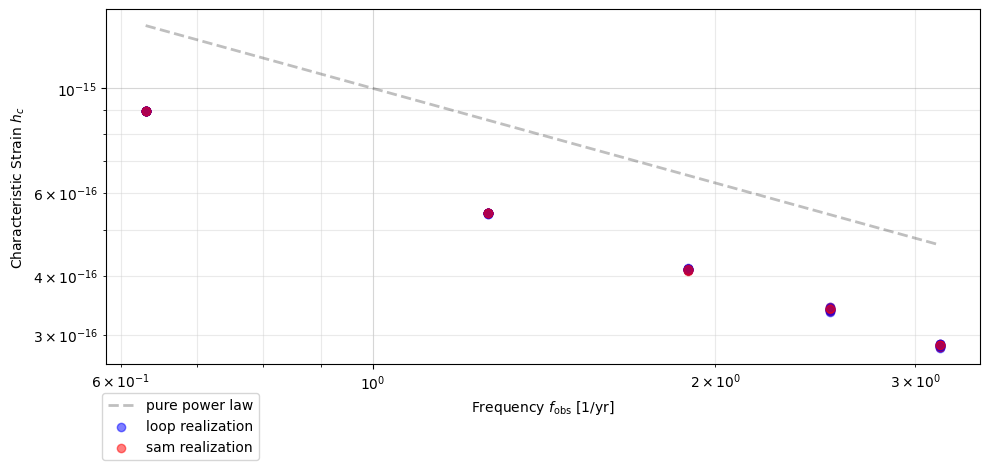

In [96]:
# Plot just this one realization
fig, ax = plot.figax(xlabel='Frequency $f_\mathrm{obs}$ [1/yr]', 
                    ylabel='Characteristic Strain $h_c$', figsize=[10,4.5])

xx = fobs * YR

# plot a reference, pure power-law  strain spectrum:   h_c(f) = 1e-15 * (f * yr) ^ -2/3
yy = 1e-15 * np.power(xx, -2.0/3.0)
ax.plot(xx, yy, 'k--', alpha=0.25, lw=2.0, label = 'pure power law')

# # plot the model without sampling
# # blue: my loop method
# # red: the sam method
# ax.plot(xx, hc_loopF_sum, color='b', lw=4, ls = 'solid', label='unsampled GWB spectrum by loops')
# ax.plot(xx, hc_samF_sum, color='r', lw=3, ls = 'dotted', label='unsampled GWB spectrum by sam')

# # plot the model with Poisson sampling
# add_sampleGWB_to_plot(fig, ax, hc_loop3_sum, LABEL='loop with 3 realizations', COLOR='b')
# add_sampleGWB_to_plot(fig, ax, hc_sam3_sum, LABEL='sam with 3 realizations', COLOR='r')

# plot single realizations
for idx in range(len(hc_loop10_sum[0,:])):
    if(idx==0):
        ax.scatter(xx, hc_loop10_sum[:, idx], lw=1.0, alpha=0.5, color='b', 
                label = 'loop realization')
        ax.scatter(xx, hc_sam10_sum[:, idx], lw=1.0, alpha=0.5, color='r', 
                label = 'sam realization')
    else:
        ax.scatter(xx, hc_loop10_sum[:, idx], lw=1.0, alpha=0.5, color='b')
        ax.scatter(xx, hc_sam10_sum[:, idx], lw=1.0, alpha=0.5, color='r')


legend_gwb = ax.legend(bbox_to_anchor=(.1,-.05), bbox_transform=fig.transFigure, loc='lower left')
fig.tight_layout()

## More frequencies, masses, ratios, and redshifts

In [97]:
def get_edges_and_numbers(dur, cad, mtot, mrat, redz):
    fobs = utils.nyquist_freqs(dur,cad)
    fobs_edges = utils.nyquist_freqs_edges(dur,cad)
    print(f"Number of frequency bins: {fobs.size-1}")
    print(f"  between [{fobs[0]*YR:.2f}, {fobs[-1]*YR:.2f}] 1/yr")
    print(f"          [{fobs[0]*1e9:.2f}, {fobs[-1]*1e9:.2f}] nHz")
    sam = holo.sam.Semi_Analytic_Model(mtot=mtot, mrat=mrat, 
        redz=redz)
    print('edges:', sam.edges)
    fobs_gw_edges = fobs_edges
    hard = holo.hardening.Hard_GW
    fobs_gw_cents = kale.utils.midpoints(fobs_gw_edges)
    fobs_orb_edges = fobs_gw_edges / 2.0
    fobs_orb_cents = fobs_gw_cents / 2.0


    # dynamic_binary_number
    # gets differential number of binaries per bin-vol per log freq interval
    edges, dnum = sam.dynamic_binary_number(hard, fobs_orb=fobs_orb_cents)
    edges[-1] = fobs_orb_edges

    # integrate (multiply by bin volume) within each bin
    number = utils._integrate_grid_differential_number(edges, dnum, freq=False)
    number = number * np.diff(np.log(fobs_gw_edges))
    return edges, number

frequency bins/edges

In [98]:
dur2 = 5.0*YR
cad2 = .2*YR
mtot2=(1.0e4*MSOL, 1.0e11*MSOL, 20)
mrat2=(1e-3, 1.0, 25)
redz2=(1e-3, 1.0, 15)
edges2, number2 = get_edges_and_numbers(dur2, cad2, mtot2, mrat2, redz2)

Number of frequency bins: 11
  between [0.20, 2.40] 1/yr
          [6.34, 76.05] nHz
edges: [array([1.9884e+37, 4.6444e+37, 1.0848e+38, 2.5338e+38, 5.9182e+38,
       1.3823e+39, 3.2287e+39, 7.5414e+39, 1.7615e+40, 4.1143e+40,
       9.6098e+40, 2.2446e+41, 5.2427e+41, 1.2246e+42, 2.8602e+42,
       6.6807e+42, 1.5604e+43, 3.6447e+43, 8.5130e+43, 1.9884e+44]), array([0.001 , 0.0013, 0.0018, 0.0024, 0.0032, 0.0042, 0.0056, 0.0075,
       0.01  , 0.0133, 0.0178, 0.0237, 0.0316, 0.0422, 0.0562, 0.075 ,
       0.1   , 0.1334, 0.1778, 0.2371, 0.3162, 0.4217, 0.5623, 0.7499,
       1.    ]), array([0.001 , 0.0016, 0.0027, 0.0044, 0.0072, 0.0118, 0.0193, 0.0316,
       0.0518, 0.0848, 0.1389, 0.2276, 0.3728, 0.6105, 1.    ])]


get strain (this gives lam value to large on windows)

In [104]:
# get GWB spectrum
hc2_samF = holo.sam.gravwaves._gws_from_number_grid_integrated(edges2, number2, realize=False, sum=False)
hc2_sam15 = holo.sam.gravwaves._gws_from_number_grid_integrated(edges2, number2, realize=15, sum=False)
hc2_sam15_sum = holo.sam.gravwaves._gws_from_number_grid_integrated(edges2, number2, realize=15, sum=True)

hc2_loopF = gws_by_loops(edges2, number2, realize=False)    
hc2_loop15 = gws_by_loops(edges2, number2, realize=15)   
hc2_loop15_sum = np.sqrt(np.sum(hc2_loop15**2, axis=(0, 1, 2)))
        

19:15:48 ERROR : lam value too large [gravwaves.py:_gws_from_number_grid_integrated]
utils.stats(number)='0.00e+00, 0.00e+00, 0.00e+00, 2.28e-56, 8.61e+03, 1.09e+07, 2.04e+12'
number.max()=2.03746062e+12
number.dtype=dtype('float64')


ValueError: lam value too large

plot

In [ ]:
# Plot just this one realization
fig, ax = plot.figax(xlabel='Frequency $f_\mathrm{obs}$ [1/yr]', 
                    ylabel='Characteristic Strain $h_c$', figsize=[10,4.5])

xx = fobs * YR

# plot a reference, pure power-law  strain spectrum:   h_c(f) = 1e-15 * (f * yr) ^ -2/3
yy = 1e-15 * np.power(xx, -2.0/3.0)
ax.plot(xx, yy, 'k--', alpha=0.25, lw=2.0, label = 'pure power law')

# plot the model without sampling
# blue: my loop method
# red: the sam method
ax.plot(xx, hc2_loopF_sum, color='b', lw=4, ls = 'solid', label='unsampled GWB spectrum2 by loops')
ax.plot(xx, hc2_samF_sum, color='r', lw=3, ls = 'dotted', label='unsampled GWB spectrum2 by sam')

# plot the model with Poisson sampling
add_sampleGWB_to_plot(fig, ax, hc2_loop115_sum, LABEL='loop2 with 15 realizations', COLOR='b')
add_sampleGWB_to_plot(fig, ax, hc2_sam115_sum, LABEL='sam2 with 15 realizations', COLOR='r')

# plot single realizations
# ax.plot(xx, hc_loop10_sum[:, 0], lw=4.0, alpha=0.6, color='green', linestyle = 'dotted',
#         label = 'loop realization')
# ax.plot(xx, hc_sam10_sum[:, 0], lw=4.0, alpha=0.6, color='purple', linestyle = 'dotted',
#         label = 'sam realization')


legend_gwb = ax.legend(bbox_to_anchor=(.1,-.15), bbox_transform=fig.transFigure, loc='lower left')
fig.tight_layout()